In [1]:
import warnings
warnings.filterwarnings(action = 'ignore')
from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


In [2]:
import keras
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
from keras.layers import Convolution1D, MaxPool1D, Flatten, Activation, Dense, GlobalAveragePooling1D, Input,Dropout, LeakyReLU, BatchNormalization
from keras.models import Sequential, Model, load_model
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.optimizers import Nadam,Adam, SGD
from keras.utils import to_categorical 

Using TensorFlow backend.


In [0]:
train = pd.read_csv('/gdrive/My Drive/Titanic/train.csv')
test = pd.read_csv('/gdrive/My Drive/Titanic/test.csv')
submission = pd.read_csv('/gdrive/My Drive/Titanic/gender_submission.csv')

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [5]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [6]:
submission

,PassengerId,Survived
0,892,NaN
1,893,NaN
2,894,NaN
3,895,NaN
4,896,NaN
...,...,...
413,1305,NaN
414,1306,NaN
415,1307,NaN
416,1308,NaN


# 전처리
## Name -> 칭호만 분리


In [7]:
train.iloc[0]['Name']

'Braund, Mr. Owen Harris'

In [0]:
for ind,name in enumerate(train['Name']):
  train.loc[train.PassengerId == ind+1,'Name'] = name.split('.')[0].split(' ')[-1]

for ind,name in enumerate(test['Name']):
  test.loc[test.index == ind,'Name'] = name.split('.')[0].split(' ')[-1]


In [9]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,Mr,male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,Mrs,female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,Miss,female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,Mrs,female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,Mr,male,35.0,0,0,373450,8.0500,NaN,S


In [10]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,Mr,male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,Mrs,female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,Mr,male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,Mr,male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,Mrs,female,22.0,1,1,3101298,12.2875,NaN,S


## Cabin -> 알파벳 분리

In [0]:
for ind,cabin in enumerate(train['Cabin']):
  if type(cabin) == float:
    continue
  train.loc[train.PassengerId == ind+1,'Cabin'] = cabin[0]#알파벳만 분리

In [12]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,Mr,male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,Mrs,female,38.0,1,0,PC 17599,71.2833,C,C
2,3,1,3,Miss,female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,Mrs,female,35.0,1,0,113803,53.1000,C,S
4,5,0,3,Mr,male,35.0,0,0,373450,8.0500,NaN,S


In [13]:
for ind,cabin in enumerate(test['Cabin']):
  if type(cabin) == float:
    continue
  test.loc[test.index == ind,'Cabin'] = cabin[0]
test.tail()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
413,1305,3,Mr,male,NaN,0,0,A.5. 3236,8.0500,NaN,S
414,1306,1,Dona,female,39.0,0,0,PC 17758,108.9000,C,C
415,1307,3,Mr,male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
416,1308,3,Mr,male,NaN,0,0,359309,8.0500,NaN,S
417,1309,3,Master,male,NaN,1,1,2668,22.3583,NaN,C


## object -> int

In [14]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


--> Object 타입:Name, Sex, Ticket, Cabin, Embarked

- Name 칭호별 인덱싱

In [0]:
t_set = set(train.Name)|set(test.Name)
dic_Name = {i:j for i,j in zip(t_set,[k for k in range(len(t_set))])}

In [16]:
dic_Name

{'Capt': 8,
 'Col': 10,
 'Countess': 3,
 'Don': 15,
 'Dona': 11,
 'Dr': 2,
 'Jonkheer': 14,
 'Lady': 7,
 'Major': 5,
 'Master': 12,
 'Miss': 0,
 'Mlle': 6,
 'Mme': 17,
 'Mr': 1,
 'Mrs': 16,
 'Ms': 9,
 'Rev': 13,
 'Sir': 4}

In [0]:
for k,v in dic_Name.items():
  train['Name'].replace(k,v,inplace = True)
  test['Name'].replace(k,v,inplace = True)

In [18]:
train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,1,male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,16,female,38.0,1,0,PC 17599,71.2833,C,C
2,3,1,3,0,female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,16,female,35.0,1,0,113803,53.1000,C,S
4,5,0,3,1,male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,13,male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,0,female,19.0,0,0,112053,30.0000,B,S
888,889,0,3,0,female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,1,male,26.0,0,0,111369,30.0000,C,C


In [19]:
test

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,1,male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,16,female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,1,male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,1,male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,16,female,22.0,1,1,3101298,12.2875,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,1,male,NaN,0,0,A.5. 3236,8.0500,NaN,S
414,1306,1,11,female,39.0,0,0,PC 17758,108.9000,C,C
415,1307,3,1,male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
416,1308,3,1,male,NaN,0,0,359309,8.0500,NaN,S


In [20]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null int64
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(6), object(4)
memory usage: 83.7+ KB


In [21]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null int64
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(5), object(4)
memory usage: 36.0+ KB


- Sex 인덱싱


In [0]:
dic_Sex = {'female':0, 'male':1}

In [0]:
for k,v in dic_Sex.items():
  train['Sex'].replace(k,v, inplace =True)
  test['Sex'].replace(k,v,inplace=True)


In [24]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null int64
Sex            891 non-null int64
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(7), object(3)
memory usage: 83.7+ KB


In [25]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null int64
Sex            418 non-null int64
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(6), object(3)
memory usage: 36.0+ KB


- Cabin 인덱싱

In [26]:
set_cabin = set(train.Cabin)|set(test.Cabin)
set_cabin

{'A', 'B', 'C', 'D', 'E', 'F', 'G', 'T', nan}

In [0]:
dic_cabin = {i:e for e,i in enumerate(set_cabin)}

In [28]:
dic_cabin

{'A': 5, 'B': 6, 'C': 1, 'D': 4, 'E': 2, 'F': 8, 'G': 7, 'T': 3, nan: 0}

In [0]:
for k,v in dic_cabin.items():
  train['Cabin'].replace(k,v,inplace = True)
  test['Cabin'].replace(k,v,inplace = True)

In [30]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null int64
Sex            891 non-null int64
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          891 non-null int64
Embarked       889 non-null object
dtypes: float64(2), int64(8), object(2)
memory usage: 83.7+ KB


In [31]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null int64
Sex            418 non-null int64
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          418 non-null int64
Embarked       418 non-null object
dtypes: float64(2), int64(7), object(2)
memory usage: 36.0+ KB


- Embarked 인덱싱

In [32]:
set_Embarked = set(train.Embarked)|set(test.Embarked)
set_Embarked

{'C', 'Q', 'S', nan}

In [0]:
dic_Embarked = {i:e for e,i in enumerate(set_Embarked)}
for k,v in dic_Embarked.items():
  train['Embarked'].replace(k,v, inplace = True)
  test['Embarked'].replace(k,v, inplace = True)


In [34]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null int64
Sex            891 non-null int64
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          891 non-null int64
Embarked       891 non-null int64
dtypes: float64(2), int64(9), object(1)
memory usage: 83.7+ KB


In [35]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null int64
Sex            418 non-null int64
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          418 non-null int64
Embarked       418 non-null int64
dtypes: float64(2), int64(8), object(1)
memory usage: 36.0+ KB


- Ticket 살펴보기

In [0]:
#set(test.Ticket)

In [0]:
#set(train.Ticket)

In [0]:
Ticket_cnt =pd.DataFrame([len(set(train.Ticket)), len(set(test.Ticket)), len(set(train.Ticket)|set(test.Ticket))], ['train','test','train+test'], columns = ['type_count'])

In [39]:
Ticket_cnt

,type_count
train,681
test,363
train+test,929


-------------------------------
train, test 각각의 샘플에서 Ticket번호가 겹치는 경우도 있고,
<br>
train+test에서도 같은 Ticket번호가 있다.
<br>
위에서 살펴본 바, 길이 3이 가장 짧은 길이의 Ticket 번호이다. 
<br> 
따라서 Ticket번호 길이를 모두 3으로 잘라내는 건 어떨까


---



In [0]:
for ind,ticket in enumerate(train.Ticket):
  train.loc[train.index == ind, 'Ticket'] = ticket[:3] 

for ind,ticket in enumerate(test.Ticket):
  test.loc[test.index == ind, 'Ticket'] = ticket[:3] 

In [41]:
Ticket_cnt['type_count(after)'] = [len(set(train.Ticket)), len(set(test.Ticket)),len( set(train.Ticket)|set(test.Ticket))]
Ticket_cnt

,type_count,type_count(after)
train,681,154
test,363,117
train+test,929,171


In [0]:
#많이 줄어들었으니, 이것도 인덱싱 해보자
set_ticket = set(train.Ticket)|set(test.Ticket)
#set_ticket

In [0]:
dic_ticket = {i:e for e,i in enumerate(set_ticket)}
#dic_ticket

In [0]:
for k,v in dic_ticket.items():
  train['Ticket'].replace(k,v, inplace = True)
  test['Ticket'].replace(k,v, inplace = True)

In [45]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null int64
Sex            891 non-null int64
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null int64
Fare           891 non-null float64
Cabin          891 non-null int64
Embarked       891 non-null int64
dtypes: float64(2), int64(10)
memory usage: 83.7 KB


In [46]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null int64
Sex            418 non-null int64
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null int64
Fare           417 non-null float64
Cabin          418 non-null int64
Embarked       418 non-null int64
dtypes: float64(2), int64(9)
memory usage: 36.0 KB


### Cabin이 B,D,E인 승객 표시 -> Cabin_s

예전 분석에 따르면,<br> Cabin이 B,D,E에 해당하는 승객의 생존율이 높았다.(대부분이 Pclass가 1이기도 했음)<br>이걸 바탕으로 Cabin_s라는 새로운 컬럼을 생성하고, 각 승객의 Cabin이 B,D,E 해당 여부(0,1)를 값으로 넣어보자.


In [47]:
#인덱스 확인
dic_cabin

{'A': 5, 'B': 6, 'C': 1, 'D': 4, 'E': 2, 'F': 8, 'G': 7, 'T': 3, nan: 0}

In [0]:
def train_cabin(x):
  if train.iloc[x].Cabin in [dic_cabin['B'],dic_cabin['D'], dic_cabin['E']]:
    return 1
  return 0

def test_cabin(x):
  if test.iloc[x].Cabin in [dic_cabin['B'],dic_cabin['D'], dic_cabin['E']]:
    return 1
  return 0
  
train['Cabin_s'] = [train_cabin(x) for x in train.index]
test['Cabin_s'] = [test_cabin(x) for x in test.index]

In [49]:
train.Cabin_s.value_counts()

0    779
1    112
Name: Cabin_s, dtype: int64

In [50]:
test.Cabin_s.value_counts()

0    378
1     40
Name: Cabin_s, dtype: int64

### Sibsp + Parch = Family

예전 분석에 따라 Sibsp과 Parch 값의 합으로 구성된 Family 컬럼을 생성해보자

In [0]:
train['Family'] = train.SibSp + train.Parch

In [52]:
train.tail(7)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Cabin_s,Family
884,885,0,3,1,1,25.0,0,0,88,7.050,0,3,0,0
885,886,0,3,16,0,39.0,0,5,84,29.125,0,2,0,5
886,887,0,2,13,1,27.0,0,0,54,13.000,0,3,0,0
887,888,1,1,0,0,19.0,0,0,80,30.000,6,3,1,0
888,889,0,3,0,0,NaN,1,2,116,23.450,0,3,0,3
889,890,1,1,1,1,26.0,0,0,141,30.000,1,1,0,0
890,891,0,3,1,1,32.0,0,0,89,7.750,0,2,0,0


In [0]:
test['Family'] = test.Parch + test.SibSp

## 결측치 처리

In [54]:
#Age는 mean으로 채우기
train.Age.fillna(value = train.Age.mean(),axis = 0,inplace = True)
train.describe()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Cabin_s,Family
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,3.600449,0.647587,29.699118,0.523008,0.381594,77.474747,32.204208,0.838384,2.529742,0.125701,0.904602
std,257.353842,0.486592,0.836071,5.710208,0.477990,13.002015,1.102743,0.806057,46.591389,49.693429,1.894026,0.800254,0.331699,1.613459
min,1.000000,0.000000,1.000000,0.000000,0.000000,0.420000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,1.000000,0.000000,22.000000,0.000000,0.000000,41.000000,7.910400,0.000000,2.000000,0.000000,0.000000
50%,446.000000,0.000000,3.000000,1.000000,1.000000,29.699118,0.000000,0.000000,86.000000,14.454200,0.000000,3.000000,0.000000,0.000000
75%,668.500000,1.000000,3.000000,1.000000,1.000000,35.000000,1.000000,0.000000,116.000000,31.000000,0.000000,3.000000,0.000000,1.000000
max,891.000000,1.000000,3.000000,17.000000,1.000000,80.000000,8.000000,6.000000,170.000000,512.329200,8.000000,3.000000,1.000000,10.000000


In [55]:
test.Age.fillna(value = test.Age.mean(), axis = 0,inplace = True)
test.describe()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Cabin_s,Family
count,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,417.000000,418.000000,418.000000,418.000000,418.000000
mean,1100.500000,2.265550,4.095694,0.636364,30.272590,0.447368,0.392344,74.660287,35.627188,0.763158,2.401914,0.095694,0.839713
std,120.810458,0.841838,6.082599,0.481622,12.634534,0.896760,0.981429,48.674758,55.907576,1.845048,0.854496,0.294523,1.519072
min,892.000000,1.000000,0.000000,0.000000,0.170000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,996.250000,1.000000,1.000000,0.000000,23.000000,0.000000,0.000000,32.500000,7.895800,0.000000,2.000000,0.000000,0.000000
50%,1100.500000,3.000000,1.000000,1.000000,30.272590,0.000000,0.000000,70.000000,14.454200,0.000000,3.000000,0.000000,0.000000
75%,1204.750000,3.000000,1.000000,1.000000,35.750000,1.000000,0.000000,114.000000,31.500000,0.000000,3.000000,0.000000,1.000000
max,1309.000000,3.000000,16.000000,1.000000,76.000000,8.000000,9.000000,170.000000,512.329200,8.000000,3.000000,1.000000,10.000000


In [56]:
#Fare도 mean으로 채우기
test.Fare.fillna(value = test.Fare.mean(), axis=0, inplace = True)
test.describe()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Cabin_s,Family
count,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000
mean,1100.500000,2.265550,4.095694,0.636364,30.272590,0.447368,0.392344,74.660287,35.627188,0.763158,2.401914,0.095694,0.839713
std,120.810458,0.841838,6.082599,0.481622,12.634534,0.896760,0.981429,48.674758,55.840500,1.845048,0.854496,0.294523,1.519072
min,892.000000,1.000000,0.000000,0.000000,0.170000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,996.250000,1.000000,1.000000,0.000000,23.000000,0.000000,0.000000,32.500000,7.895800,0.000000,2.000000,0.000000,0.000000
50%,1100.500000,3.000000,1.000000,1.000000,30.272590,0.000000,0.000000,70.000000,14.454200,0.000000,3.000000,0.000000,0.000000
75%,1204.750000,3.000000,1.000000,1.000000,35.750000,1.000000,0.000000,114.000000,31.500000,0.000000,3.000000,0.000000,1.000000
max,1309.000000,3.000000,16.000000,1.000000,76.000000,8.000000,9.000000,170.000000,512.329200,8.000000,3.000000,1.000000,10.000000


# 피처 선택

In [0]:
feature_all = ['Pclass','Name','Sex','Age','SibSp','Parch','Ticket','Fare','Cabin','Embarked']
feature_all2 = ['Pclass','Name','Sex','Age','SibSp','Parch','Ticket','Fare','Cabin','Embarked', 'Cabin_s','Family']
feature5_1 = ['Pclass', 'Sex','SibSp','Parch','Fare']
feature5_2 = ['Pclass', 'Name','SibSp','Parch','Fare']
feature5_3 = ['Pclass', 'Name', 'Family', 'Cabin_s','Fare']
feature5_4 = ['Pclass','Sex','Family','Cabin_s','Fare']

feature6_1 = ['Pclass', 'Name','Age','SibSp','Parch','Fare']
feature6_2 = ['Pclass', 'Sex','Age','SibSp','Parch','Fare']
feature6_3 = ['Pclass', 'Name','Age','Family','Fare', 'Cabin_s']
feature6_4 = ['Pclass', 'Sex','Age','Family','Fare','Cabin_s']


In [0]:

def model1(n):
  model = Sequential()
  model.add(Dense(units= 10, activation = 'selu',input_shape=(n,)))
  model.add(Dense(units =20, activation = 'selu'))
  model.add(Dense(units= 30, activation='selu'))
  model.add(Dense(units= 40, activation='selu'))
  model.add(Dense(units= 50, activation='selu'))
  model.add(Dropout(0.3))
  model.add(Dense(units= 1, activation='sigmoid'))
  return model


In [0]:
def model2(n):
  model = Sequential()
  model.add(Dense(units =25, activation = 'selu', input_shape = (n,)))
  model.add(Dense(units = 50, activation='selu'))
  model.add(Dropout(0.2))
  model.add(Dense(units=1, activation = 'sigmoid'))
  return model

In [0]:
from keras.utils.vis_utils import plot_model
feature = feature6_4
n = len(feature)
model = model1(n)
#plot_model(model,to_file='/gdrive/My Drive/Titanic/Titanic_model+{}.png'.format(n), show_shapes=True, show_layer_names=True)

In [60]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 10)                60        
_________________________________________________________________
dense_2 (Dense)              (None, 20)                220       
_________________________________________________________________
dense_3 (Dense)              (None, 30)                630       
_________________________________________________________________
dense_4 (Dense)              (None, 40)                1240      
_________________________________________________________________
dense_5 (Dense)              (None, 50)                2050      
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                

In [0]:
train_X = train[feature]
train_Y = train['Survived']
test_X = test[feature]
bat_s = 10
feature_n = '6_4'
#model.load_weights(f'/gdrive/My Drive/Check/model1_feature{feature_n}_b{bat_s}_500.h5')
ep=600
model.compile(optimizer = Adam(lr=0.001),metrics = ['accuracy'], loss='binary_crossentropy')
#모델을 학습합니다.
model_ch = ModelCheckpoint(f'/gdrive/My Drive/Check/model1_feature{feature_n}_b{bat_s}'+'_{epoch}.h5',save_weights_only=True,period= 100) 
hist = model.fit(train_X, train_Y, epochs=ep, batch_size=10, validation_split = 0.3, verbose = 1, shuffle = True,callbacks=[model_ch])
#model.save('/gdrive/My Drive/Titanic/model1.h5')

pred_test = model.predict(test_X)
submission['Survived'] = [int(np.round(i)) for i in pred_test]
submission.to_csv(f'/gdrive/My Drive/Titanic/feature{feature_n}_model1_{ep}_b{bat_s}.csv',index=False)
submission

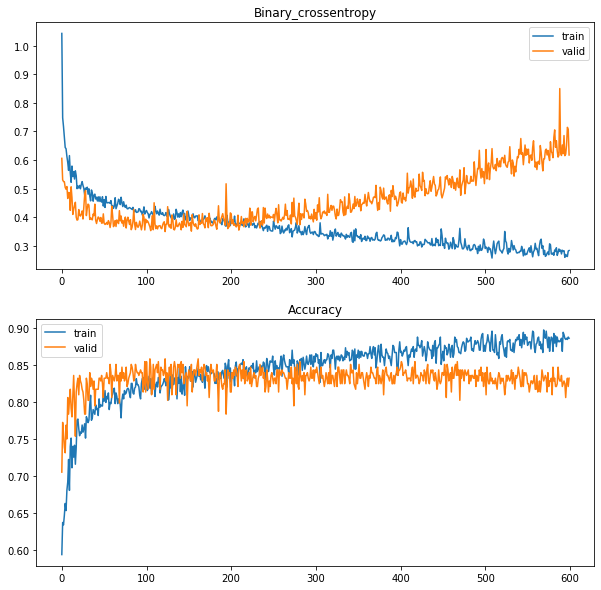

In [124]:
plt.figure(figsize = (10,10))
plt.subplot(211)
plt.title('Binary_crossentropy')
plt.plot(hist.history['loss'], label = 'train')
plt.plot(hist.history['val_loss'], label = 'valid')
plt.legend()

plt.subplot(212)
plt.title('Accuracy')
plt.plot(hist.history['acc'], label = 'train')
plt.plot(hist.history['val_acc'], label = 'valid')
plt.legend()

In [125]:
submission['Survived'].value_counts()

0    266
1    152
Name: Survived, dtype: int64

In [0]:
model = model1(n) 
e = '200'
model.load_weights(f'/gdrive/My Drive/Check/model1_feature{feature_n}_b{batch_s}_{e}.h5')

In [130]:
pred_test = model.predict(test_X)
submission['Survived'] = [int(np.round(i)) for i in pred_test]
submission.to_csv(f'/gdrive/My Drive/Titanic/feature{feature_n}_model1_{e}.csv',index=False)
submission

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [131]:
 submission['Survived'].value_counts()

0    233
1    185
Name: Survived, dtype: int64